In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

In [8]:
from sklearn.datasets import load_boston
boston = load_boston()

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
boston.data.shape

(506, 13)

In [6]:
boston.target.shape

(506,)

In [9]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [8]:
data.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [9]:
pearson = data.corr(method="pearson")
pearson["MEDV"].drop("MEDV").sort_values(ascending=False)

RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

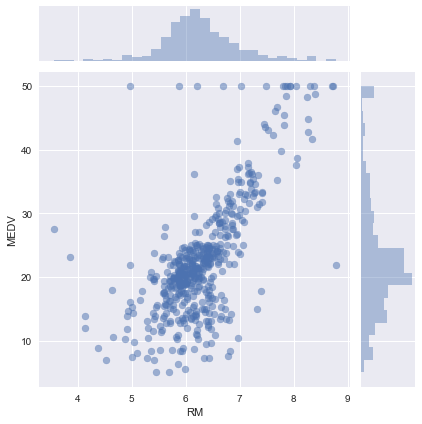

In [10]:
sns.jointplot(data["RM"], data["MEDV"], kind="scatter", joint_kws={"alpha":0.5});

In [11]:
data[["RM", "MEDV"]].describe()

,RM,MEDV
count,506.000000,506.000000
mean,6.284634,22.532806
std,0.702617,9.197104
min,3.561000,5.000000
25%,5.885500,17.025000
50%,6.208500,21.200000
75%,6.623500,25.000000
max,8.780000,50.000000


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from math import sqrt

In [3]:
class GDRegressor:
    
    def __init__(self, alpha=0.01, n_iter=100, progress=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.disable = not progress

    def fit(self, X, y):
        precision = 0.001

        m = len(X)
        self.theta = [0.33] * 2
        theta_old = [0] * 2
        self.grad = [0] * 2

        y_hypoth = [0] * len(y)

        for j in range(self.n_iter):
            theta_old[0], theta_old[1] = self.theta[0], self.theta[1]

            y_hypoth = [self.theta[0] + self.theta[1] * X[i] for i in range(m)]
            self.grad[0] = sum([y_hypoth[i] - y[i] for i in range(m)]) / m
            self.grad[1] = sum([(y_hypoth[i] - y[i]) * X[i] for i in range(m)]) / m
            
            check, diff = self.gradient_check(X, y)
            if not check:
                print("gradient isn't correct", check, diff)
                return

            self.theta[0] -= self.alpha * self.grad[0]
            self.theta[1] -= self.alpha * self.grad[1]

            if j != 0 and abs(self.theta[0] - theta_old[0]) < precision and abs(
                    self.theta[1] - theta_old[1]) < precision:
                break

        self.intercept_, self.slope_ = self.theta[0], self.theta[1]

    def predict(self, X_test):
        y = [0] * len(X_test)
        for i in range(len(y)):
            y[i] = self.intercept_ + self.slope_ * X_test[i]
        return y

    def gradient_check(self, X, y):
        e = 10e-7
        m = len(X)
        diff = [-1] * 2

        # theta_0
        J_plus = sum([(self.theta[0] + e + self.theta[1] * X[i] - y[i]) ** 2 for i in range(m)]) / (2 * m)
        J_minus = sum([(self.theta[0] - e + self.theta[1] * X[i] - y[i]) ** 2 for i in range(m)]) / (2 * m)
        diff[0] = abs((J_plus - J_minus) / (2 * e) - self.grad[0])
        if diff[0] > e:
            return False, diff

        # theta_1
        J_plus = sum([(self.theta[0] + (self.theta[1] + e) * X[i] - y[i]) ** 2 for i in range(m)]) / (2 * m)
        J_minus = sum([(self.theta[0] + (self.theta[1] - e) * X[i] - y[i]) ** 2 for i in range(m)]) / (2 * m)
        diff[1] = abs((J_plus - J_minus) / (2 * e) - self.grad[1])
        if diff[1] > e:
            return False, diff
        return True, diff

In [4]:
def rmse(y_hypoth, y):
    m = len(y)
    t = sum([(y[i] - y_hypoth[i]) ** 2 for i in range(m)])
    return sqrt(t / m)

In [5]:
def r_squared(y_hypoth, y):
    m = len(y)
    y_mean = sum(y) / m
    s1 = sum([(y_hypoth[i] - y_mean) ** 2 for i in range(m)])
    s2 = sum([(y[i] - y_mean) ** 2 for i in range(m)])
    return 1 - s1 / s2

In [10]:
# data

X = list(data["RM"])
y = list(data["MEDV"])

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.03, n_iter=10000)
%time model.fit(X_train, Y_train)

Wall time: 7.73 s


In [12]:
print(model.slope_, model.intercept_)

9.163817088913566 -35.029537224200666


In [13]:
Y_hypoth = model.predict(X_train)

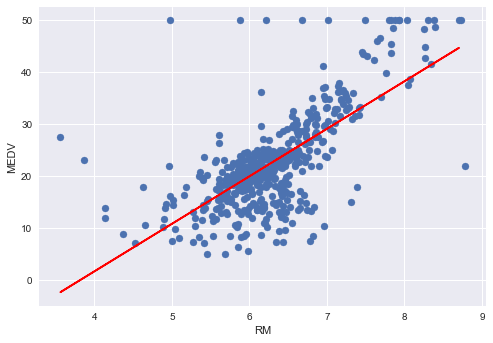

In [14]:
plt.scatter(data["RM"], data["MEDV"])
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.plot(X_train, [model.slope_ * x + model.intercept_ for x in X_train], "r")

In [15]:
rmse(Y_hypoth, Y_test), r_squared(Y_hypoth, Y_test)

(10.705504157600569, 0.5242715382596029)

In [16]:
# без выбросов

X_filtered = list(data[(data["MEDV"] < 50)]["RM"])
y_filtered = list(data[(data["MEDV"] < 50)]["MEDV"])

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, y_filtered, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.04, n_iter=10000)
%time model.fit(X_train, Y_train)

Wall time: 5.68 s


In [18]:
Y_hypoth = model.predict(X_test)

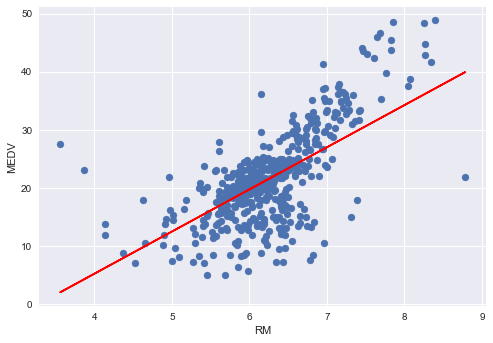

In [19]:
plt.scatter(X_filtered, y_filtered)
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.plot(X_train, [model.slope_ * x + model.intercept_ for x in X_train], "r")

In [20]:
rmse(Y_hypoth, Y_test), r_squared(Y_hypoth, Y_test)

(5.705356201687487, 0.6436872136920211)

In [21]:
def z_scaler(X):
    x_mean = sum(X) / len(X)
    std_dev = sqrt(sum([(x - x_mean) ** 2 for x in X]) / (len(X) - 1))
    return [(x - x_mean) / std_dev for x in X]

In [22]:
def min_max(X):
    return [(x - min(X)) / (max(X) - min(X)) for x in X]

In [23]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.01, n_iter=10000)
%time model.fit(X_train, Y_train)

Wall time: 116 ms


In [25]:
Y_hypoth = model.predict(X_test)
rmse(Y_hypoth, Y_test), r_squared(Y_hypoth, Y_test)

(0.7404703417766504, 0.7099601191159737)

In [26]:
X_scaled = min_max(X_filtered)
y_scaled = min_max(y_filtered)

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.01, n_iter=10000)
%time model.fit(X_train, Y_train)

Wall time: 19.9 ms


In [28]:
Y_hypoth = model.predict(X_test)
rmse(Y_hypoth, Y_test), r_squared(Y_hypoth, Y_test)

(0.18182571083628166, 0.7783707811171945)

In [29]:
from sklearn.linear_model import SGDRegressor

max_iter = 10000
eta0 = 0.0001
model = SGDRegressor(
    loss='squared_loss',
    learning_rate='constant',
    max_iter=max_iter,
    eta0=eta0
)

In [30]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(np.array(X_train).reshape(-1, 1))
Y_train = y_scaler.fit_transform(np.array(Y_train).reshape(-1, 1))
X_test = x_scaler.transform(np.array(X_test).reshape(-1, 1))
Y_test = y_scaler.transform(np.array(Y_test).reshape(-1, 1))

In [31]:
model.fit(X_train, Y_train.ravel())

SGDRegressor(eta0=0.0001, learning_rate='constant', max_iter=10000)

In [32]:
Y_hypoth = model.predict(X_test)

In [33]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

r2_score(Y_test, Y_hypoth), mean_squared_error(Y_test, Y_hypoth)

(0.49629738767394427, 0.487653617840957)

In [34]:
model.coef_, model.intercept_

(array([0.55200271]), array([-2.25333613e-05]))

In [35]:
mean_squared_error(Y_test, Y_hypoth), r2_score(Y_test, Y_hypoth)

(0.487653617840957, 0.49629738767394427)

In [36]:
class MiniBatchGDR:

    def __init__(self, alpha=0.01, epochs=100, batch_size=10, progress=True):
        self.alpha = alpha
        self.epochs = epochs
        self.disable = not progress
        self.batch_size = batch_size

    def fit(self, X, y):
        precision = 0.001

        m = len(X)
        self.theta = [0.33] * 2
        theta_old = [0] * 2
        self.grad = [0] * 2

        for j in range(self.epochs):
            theta_old[0], theta_old[1] = self.theta[0], self.theta[1]

            for k in range(0, m, self.batch_size):
                size = min(self.batch_size, m - k)
                start = k
                stop = k + size
#                 print('start =', start, 'stop =', stop, 'size =', size)

                y_hypoth = [self.theta[0] + self.theta[1] * X[i] for i in range(start, stop)]
                self.grad[0] = sum([y_hypoth[i - start] - y[i] for i in range(start, stop)]) / size
                self.grad[1] = sum([(y_hypoth[i - start] - y[i]) * X[i] for i in range(start, stop)]) / size

#                 check, diff = self.gradient_check(X, y, start, stop)
#                 if not check:
#                     print('gradient is incorrect!', check, diff)
#                     return

                self.theta[0] -= self.alpha * self.grad[0]
                self.theta[1] -= self.alpha * self.grad[1]

            if j != 0 and abs(self.theta[0] - theta_old[0]) < precision and abs(
                    self.theta[1] - theta_old[1]) < precision:
                break

        self.intercept_, self.slope_ = self.theta[0], self.theta[1]

    def predict(self, X_test):
        y = [0] * len(X_test)
        for i in range(len(y)):
            y[i] = self.intercept_ + self.slope_ * X_test[i]
        return y

    def gradient_check(self, X, y, start, stop):
        e = 10e-7
        size = stop - start
        diff = [-1] * 2

        # theta_0
        J_plus = sum([(self.theta[0] + e + self.theta[1] * X[i] - y[i]) ** 2 for i in range(start, stop)]) / (2 * size)
        J_minus = sum([(self.theta[0] - e + self.theta[1] * X[i] - y[i]) ** 2 for i in range(start, stop)]) / (2 * size)
        diff[0] = abs((J_plus - J_minus) / (2 * e) - self.grad[0])
        if diff[0] > e:
            return False, diff

        # theta_1
        J_plus = sum([(self.theta[0] + (self.theta[1] + e) * X[i] - y[i]) ** 2 for i in range(start, stop)]) / (2 * size)
        J_minus = sum([(self.theta[0] + (self.theta[1] - e) * X[i] - y[i]) ** 2 for i in range(start, stop)]) / (2 * size)
        diff[1] = abs((J_plus - J_minus) / (2 * e) - self.grad[1])
        if diff[1] > e:
            return False, diff
        return True, diff

In [37]:
X_filtered = list(data[(data["MEDV"] < 50)]["RM"])
y_filtered = list(data[(data["MEDV"] < 50)]["MEDV"])

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, y_filtered, test_size=0.33, random_state=18)
model = MiniBatchGDR(alpha=0.03, epochs=10000, batch_size=10)
%time model.fit(X_train, Y_train)

Wall time: 196 ms


In [39]:
Y_hypoth = model.predict(X_test)
rmse(Y_hypoth, Y_test), r_squared(Y_hypoth, Y_test)

(5.631356281290914, 0.6078833780504185)

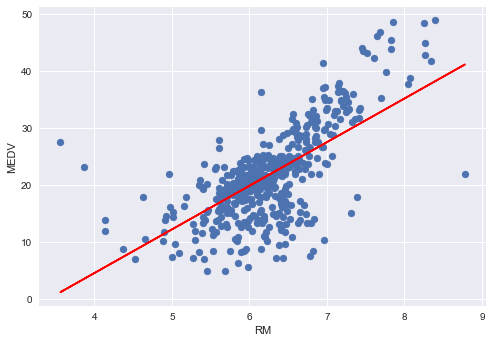

In [44]:
plt.scatter(X_filtered, y_filtered)
plt.xlabel("RM")
plt.ylabel("MEDV")
plt.plot(X_train, [model.slope_ * x + model.intercept_ for x in X_train], "r")

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, y_filtered, test_size=0.33, random_state=18)
set_sizes = [1, 10, 50, 100, 150, 200, 250, 300, 328]
train_mse = [0] * len(set_sizes)
test_mse = [0] * len(set_sizes)

for j in range(len(set_sizes)):
    size = set_sizes[j]
    print(size)
    X_train_cur, Y_train_cur = X_train[:size], Y_train[:size]
    model = MiniBatchGDR(alpha=0.03, epochs=10000, batch_size=10)
    model.fit(X_train_cur, Y_train_cur)
    train_mse[j] = (sum([(model.intercept_ + model.slope_ * X_train_cur[i] - Y_train_cur[i])**2 for i in range(size)]))
    
    Y_hypoth = model.predict(X_test)
    test_mse[j] = (sum([(Y_test[i] - Y_hypoth[i])**2 for i in range(len(Y_test))]))

1
10
50
100
150
200
250
300
328


In [46]:
print(train_mse)
print(test_mse)

[1.55583953093054e-06, 143.20563234471706, 1319.015042519657, 3222.9624307848553, 4868.757660059695, 6391.910025351285, 10048.435490255923, 11289.314833769344, 10937.282241282042]
[7543.225458440014, 7328.125764635302, 5011.7361924019515, 5003.501954090871, 4946.889510472006, 5139.431955162939, 6784.5619807895255, 6154.384326342032, 5137.372117827212]


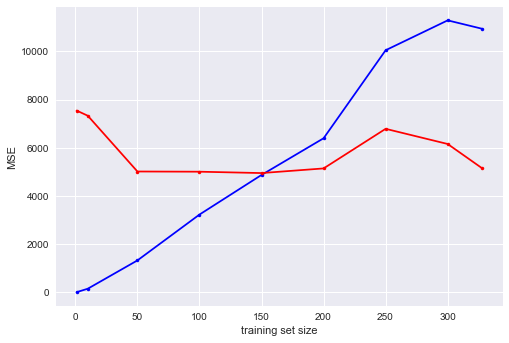

In [47]:
plt.plot(set_sizes, train_mse, '.b-')
plt.xlabel("training set size")
plt.ylabel("MSE")
plt.plot(set_sizes, test_mse, '.r-')